# 0. Setup

## 0.1. Libraries

In [1]:
# General utilities
import os
import pandas as pd
import glob
import random
import re
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np

# Image processing
from PIL import Image
import rasterio

# Custom library
from library.utilities import build_path_dictionary, print_directory_structure
from library.preprocessing import process_labelled_dataset
from library.preprocessing.labelled_dataset.find_fire_event_folders import find_fire_event_folders

## 0.2. Data paths and structure description

In [2]:
base_input_dir = '/media/pablo/Shared files/data/'  # Adjust this path to your data directory containing the labelled dataset
input_labelled_dir = os.path.join(base_input_dir, 'Satellite_burned_area_dataset') 
input_inference_dir = os.path.join('..', 'catalunya_fire_imgs')

Let's check the structure of both directories.

In [5]:
print("=== Labelled Dataset Structure ===")
print_directory_structure(input_labelled_dir)

=== Labelled Dataset Structure ===
Satellite_burned_area_dataset/
  Satellite_burned_area_dataset_part1/
    EMSR207_01MIRANDADOCORVO_02GRADING_MAP_v2_vector/
      EMSR207_01MIRANDADOCORVO_02GRADING_MAP_v2_vector_mask.png
      EMSR207_01MIRANDADOCORVO_02GRADING_MAP_v2_vector_mask.tiff
      sentinel1_2017-05-07.png
      sentinel1_2017-05-07.tiff
      sentinel1_2017-05-07_coverage.png
      sentinel1_2017-07-01.png
      sentinel1_2017-07-01.tiff
      sentinel1_2017-07-01_coverage.png
      sentinel2_2017-05-25.png
      sentinel2_2017-05-25.tiff
      sentinel2_2017-05-25_coverage.png
      sentinel2_2017-07-04.png
      sentinel2_2017-07-04.tiff
      sentinel2_2017-07-04_coverage.png
    EMSR207_02LOUSA_02GRADING_MAP_v2_vector/
      EMSR207_02LOUSA_02GRADING_MAP_v2_vector_mask.png
      EMSR207_02LOUSA_02GRADING_MAP_v2_vector_mask.tiff
      sentinel1_2017-05-07.png
      sentinel1_2017-05-07.tiff
      sentinel1_2017-05-07_coverage.png
      sentinel1_2017-05-08.png
      sent

- The whole dataset is divided into 5 parts for convenience (due to the size of the images).
- Each of the parts contains folders with images for each fire.
- Within each of the folders for each fire, there are the following images:
  - Pre-fire and post-fire images (approximately one month before and one month after the fire, respectively). They include Sentinel-1 GRD (IW mode with VV+VH polarization) and Sentinel-2 L2A images, both in `.png` and in `.tiff` (loseless format). The naming of the file is simply the product (`sentinel_x` followed by the date of acquisition of the image).
  - The coverage for each of the images, "a binary coverage mask, indicating invalid pixel values." In black, invalid pixel values, in white, valid ones.
  - Finally, the vector mask for the segmentation of the area affected by the wildfire and its severity, both in `.png` and in `.tiff` (loseless format). "Annotations released by Copernicus specify 5 different severity levels [0 = undamaged to 4 = fully destroyed], which were encoded in a greyscale image in range [0 − 255], from no damage to completely destroyed area."

> For our task, we are only interested in post-fire images in the loseless format `.tiff` (including the actual image, the coverage and the vector mask), as we want to train a model that assesses fire severity.

In [5]:
print("\n=== Catalunya Fire Images Structure ===")
print_directory_structure(input_inference_dir)


=== Catalunya Fire Images Structure ===
2015/
  images/
    sentinel2_2015-07-13_lon3-161_lat42-432.tiff
    sentinel2_2015-07-26_lon1-719_lat41-635.tiff
    sentinel2_2015-08-03_lon0-708_lat42-826.tiff
    sentinel2_2015-10-22_lon0-496_lat41-004.tiff
    sentinel2_2015-11-05_lon0-743_lat41-402.tiff
  metadata/
    sentinel2_2015-07-13_lon3-161_lat42-432.json
    sentinel2_2015-07-26_lon1-719_lat41-635.json
    sentinel2_2015-08-03_lon0-708_lat42-826.json
    sentinel2_2015-10-22_lon0-496_lat41-004.json
    sentinel2_2015-11-05_lon0-743_lat41-402.json
2016/
  images/
    sentinel2_2016-05-09_lon1-355_lat42-340.tiff
    sentinel2_2016-06-01_lon1-471_lat41-229.tiff
    sentinel2_2016-06-08_lon2-992_lat42-118.tiff
    sentinel2_2016-06-23_lon1-128_lat41-518.tiff
    sentinel2_2016-07-18_lon2-017_lat41-928.tiff
    sentinel2_2016-07-19_lon1-122_lat41-540.tiff
    sentinel2_2016-07-19_lon1-360_lat41-622.tiff
    sentinel2_2016-07-19_lon2-709_lat41-869.tiff
    sentinel2_2016-07-22_lon1-259

- One folder per fire of years.
- Each of the folder corresponding to a year has 2 folders: `images` and `metadata`.
- The `images` notebook contain the images corresponding to each retrieved wildfire in Catalunya, for Sentinel-1 GRD (IW mode and VV+VH polarization) and Sentinel-2 (L2A) data and in loseless format only (`.tiff`). 
  - All of these images correspond to the post-fire period, and retrieve the earliest satellite image (for Sentinel-2) with less than 10% cloud cover one month after the fire activation date. 
  - The minimum dimension of each of these images is of 512x512 pixels.
- The `metadata` notebook contains useful metadata associated to each image (e.g., cloud cover as provided by Copernicus, the date when the image was taken, etc.).
- The naming of the files consists on: the product (Sentinel-1 or Sentinel-2), the activation date of the fire, the longitude of the fire centroid (with 3 decimals, indicated after the dash) and the latitude of the fire centroid (same format as longitude).
- Note that there are no labels here (this dataset is just for inference).

## 0.3. Notebook description

In this notebook we preprocess the image data to prepare it for training/validation/test and for inference. To that end, we pre-process 2 different sources of data:
1) The labelled dataset from *Luca Colomba, Alessandro Farasin, Simone Monaco, Salvatore Greco, Paolo Garza, Daniele Apiletti, Elena Baralis, and Tania Cerquitelli. 2022. A Dataset for Burned Area Delineation and Severity Estimation from Satellite Imagery. In Proceedings of the 31st ACM International Conference on Information & Knowledge Management (CIKM '22). Association for Computing Machinery, New York, NY, USA, 3893–3897. https://doi.org/10.1145/3511808.3557528*. The dataset can be downloaded from here: https://zenodo.org/records/6597139 (click on "Download all", which will approximately download 14GB worth of images and labels).
2) The inference dataset for the fires in Catalunya, obtained by our own means through the APIs of [Sentinel Hub](https://dataspace.copernicus.eu/analyse/apis/sentinel-hub) (see the notebooks for part 1). 

To that end, in this notebook we follow the the pre-processing steps outlined in the paper (for consistency):
  1) Since our research question focuses on assessing the severity of fires in Catalunya (inference), we will only be using the post-fire satellite imagery (like the authors do for their binary segmentation task).
  2) Generate 512x512 pixel tiles for the labelled train, validation, test and inference data. For images whose size is not a multiple of 512, overlap of tiles is allowed (in order to cover all of the area of the image). 
  3) Additionally, during the training phase, we will randomly shuffle the tiles and apply data augmentation techniques (see the corresponding training notebook).

> The final goal is to train a model that estimates the severity of a wildfire using post-wildfire (1 month after) imagery, and then to run inference with the satellite images from wildfires in Catalunya in the last decade. Severity estimation will be done at the pixel level.

Additionally, within the paper, the authors of the dataset provide additional metadata and a suggestion for the organization of the folds for training/validation (see the `folds` column): "*[d]ata were split into 7 folds according to geographical location, such that data belonging to the same fold maintains similar morphological features.*"

This will be taken into account for training-validation.

In [6]:
df = pd.read_csv(os.path.join(input_labelled_dir, 'satellite_data.csv'))

print("Number of rows (different fires) in the DataFrame:", len(df))
print("Columns in the DataFrame:", df.columns.tolist())

df.head()

Number of rows (different fires) in the DataFrame: 73
Columns in the DataFrame: ['folder', 'top_left_long', 'top_left_lat', 'bottom_right_long', 'bottom_right_lat', 'activation_date', 'suggested_pre_date_from', 'suggested_pre_date_to', 'suggested_post_date_from', 'suggested_post_date_to', 'download_period_start', 'download_period_end', 'height', 'width', 'pre_date', 'post_date', 'situation_as_of', 'longitude', 'latitude', 'fold']


,folder,top_left_long,top_left_lat,bottom_right_long,bottom_right_lat,activation_date,suggested_pre_date_from,suggested_pre_date_to,suggested_post_date_from,suggested_post_date_to,download_period_start,download_period_end,height,width,pre_date,post_date,situation_as_of,longitude,latitude,fold
0,EMSR214_05LELAVANDOU_02GRADING_MAP_v1_vector,6.104806,43.342188,6.452223,43.065393,24/07/2017,2017-06-13,2017-07-14,2017-07-24,2017-08-24,24/06/2017,24/08/2017,522,512,14/07/2017 10:30,18/08/2017 10:34,28/07/2017,6.278515,43.203790,purple
1,EMSR207_04AVELAR_02GRADING_MAP_v2_vector,-8.499468,40.026117,-8.307374,39.904662,17/06/2017,2017-05-07,2017-06-07,2017-06-17,2017-07-18,17/05/2017,17/07/2017,512,615,NaN,NaN,20/06/2017,-8.403421,39.965389,coral
2,EMSR207_08CERNACHEDOBONJARDIM_02GRADING_MAP_v2...,-8.307667,39.904662,-8.116087,39.783514,17/06/2017,2017-05-07,2017-06-07,2017-06-17,2017-07-18,17/05/2017,17/07/2017,512,613,NaN,NaN,20/06/2017,-8.211877,39.844088,coral
3,EMSR209_01MOGUER_02GRADING_MAP_v2_vector,-6.847640,37.291966,-6.702477,37.166775,24/06/2017,2017-05-14,2017-06-14,2017-06-24,2017-07-25,24/05/2017,24/07/2017,579,512,01/06/2017 11:12,01/07/2017 11:17,NaN,-6.775058,37.229371,pink
4,EMSR298_02HAMMARSTRAND_02GRADING_MAP_v1_vector,16.361547,63.140440,16.447381,63.099674,16/07/2018,2018-06-05,2018-07-06,2018-07-16,2018-08-16,16/06/2018,16/08/2018,561,512,14/07/2018 10:30,27/07/2018 10:40,NaN,16.404464,63.120057,grey


# 1. Pre-processing the labelled data

## 1.1. Determining the tile size

In [6]:
# First, let's get the minimum dimension of the image - this will be used to 
# determine the size of the tiles we will create

# Find all individual fire event folders
# Make sure input_labelled_dir is defined before this line
all_fire_folders = find_fire_event_folders(input_labelled_dir)

min_dimension = float('inf')
min_dim_file = None

# Iterate through each folder to find the minimum image dimension
for folder in all_fire_folders:
    # Find all .tiff files in the current folder
    tiff_files = glob.glob(os.path.join(folder, "*.tiff"))
    
    for tiff_file in tiff_files:
        try:
            with rasterio.open(tiff_file) as src:
                width, height = src.width, src.height
                # Find the smaller dimension of the current image
                current_min = min(width, height)
                # If it's the smallest we've seen so far, update the overall minimum
                if current_min < min_dimension:
                    min_dimension = current_min
                    min_dim_file = tiff_file
        except Exception as e:
            print(f"Could not process file {tiff_file}: {e}")

if min_dimension != float('inf'):
    print(f"The minimum dimension found across all .tiff images is: {min_dimension} pixels.")
    print(f"File with minimum dimension: {min_dim_file}")
else:
    print("No .tiff images were found.")

Searching for dataset parts in: /media/pablo/Shared files/data/Satellite_burned_area_dataset
Found part 1 at /media/pablo/Shared files/data/Satellite_burned_area_dataset/Satellite_burned_area_dataset_part1
Found part 2 at /media/pablo/Shared files/data/Satellite_burned_area_dataset/Satellite_burned_area_dataset_part2
Found part 3 at /media/pablo/Shared files/data/Satellite_burned_area_dataset/Satellite_burned_area_dataset_part3
Found part 4 at /media/pablo/Shared files/data/Satellite_burned_area_dataset/Satellite_burned_area_dataset_part4
Found part 5 at /media/pablo/Shared files/data/Satellite_burned_area_dataset/Satellite_burned_area_dataset_part5
Found 73 fire event folders
Example folder: /media/pablo/Shared files/data/Satellite_burned_area_dataset/Satellite_burned_area_dataset_part1/EMSR207_01MIRANDADOCORVO_02GRADING_MAP_v2_vector
The minimum dimension found across all .tiff images is: 261 pixels.
File with minimum dimension: /media/pablo/Shared files/data/Satellite_burned_area_da

/home/pablo/miniconda3/envs/improc/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


The minimum dimension across all labelled `.tiff` images is of 261 pixels (which corresponds to the images in `Satellite_burned_area_dataset/Satellite_burned_area_dataset_part1/EMSR207_01MIRANDADOCORVO_02GRADING_MAP_v2_vector`). Therefore, we will create tiles for a lower dimension and a multiple of 2, 256 (half the 512x512 pixels explained in the paper).

## 1.2. Checking whether all `.tiff` images of each fire event have the same dimension

In [55]:
def find_mismatched_dimension_fires(input_labelled_dir):
    """
    Identifies fire events that contain images with different dimensions.
    
    Args:
        input_labelled_dir (str): Directory containing fire event folders
        
    Returns:
        list: Names of fire events that have images with inconsistent dimensions
    """
    # Find all fire event folders
    all_fire_folders = find_fire_event_folders(input_labelled_dir)
    mismatched_fires = []
    
    # Check each fire event folder
    for folder in all_fire_folders:
        fire_name = os.path.basename(folder)
        tiff_files = glob.glob(os.path.join(folder, "*.tiff"))
        
        # Skip fire events with no images
        if not tiff_files:
            continue
            
        dimensions = []
        
        # Collect dimensions of all images in this fire event
        for tiff_file in tiff_files:
            try:
                with rasterio.open(tiff_file) as src:
                    width, height = src.width, src.height
                    dimensions.append((width, height))
            except Exception as e:
                print(f"Could not process file {tiff_file}: {e}")
        
        # Check if all images in this fire event have the same dimensions
        if len(set(dimensions)) > 1:
            mismatched_fires.append(fire_name)
    
    # Report results
    if mismatched_fires:
        print(f"Found {len(mismatched_fires)} fire events with inconsistent image dimensions:")
        for fire in mismatched_fires:
            print(f"- {fire}")
    else:
        print("All fire events have images with consistent dimensions.")
    
    return mismatched_fires

In [56]:
# Example usage:
mismatched_fires = find_mismatched_dimension_fires(input_labelled_dir)

Searching for dataset parts in: /media/pablo/Shared files/data/Satellite_burned_area_dataset
Found part 1 at /media/pablo/Shared files/data/Satellite_burned_area_dataset/Satellite_burned_area_dataset_part1
Found part 2 at /media/pablo/Shared files/data/Satellite_burned_area_dataset/Satellite_burned_area_dataset_part2
Found part 3 at /media/pablo/Shared files/data/Satellite_burned_area_dataset/Satellite_burned_area_dataset_part3
Found part 4 at /media/pablo/Shared files/data/Satellite_burned_area_dataset/Satellite_burned_area_dataset_part4
Found part 5 at /media/pablo/Shared files/data/Satellite_burned_area_dataset/Satellite_burned_area_dataset_part5
Found 73 fire event folders
Example folder: /media/pablo/Shared files/data/Satellite_burned_area_dataset/Satellite_burned_area_dataset_part1/EMSR207_01MIRANDADOCORVO_02GRADING_MAP_v2_vector
All fire events have images with consistent dimensions.


## 1.3. Creating the tiles

Structure of the new folder:

```
tiled_fire_dataset/
  FIRE_EVENT_NAME/
    images/
      sentinel1_YYYY-MM-DD_tile_i_j.tiff
      sentinel2_YYYY-MM-DD_tile_i_j.tiff
    coverages/
      sentinel1_YYYY-MM-DD_coverage_tile_i_j.tiff
      sentinel2_YYYY-MM-DD_coverage_tile_i_j.tiff
    masks/
      FIRE_EVENT_NAME_mask_tile_i_j.tiff
```

Where `i` is the index for the tile in the horizontal axis, starting from 0 and going from left to right, and `j` is the index for the tile in the vertical axis, starting from 0 in the topmost row of tiles and increase from top to bottom. Therefore, (0, 0) is the top-left corner for each image.

In [3]:
# Set these paths according to your environment
# Use absolute paths to avoid confusion
output_directory = os.path.join(base_input_dir, 'tiled_fire_dataset')  # Base output directory for saving tiled images

In [ ]:
# Loop over the different dataset parts (5 parts overall)
for part in range(1, 6):
    base_dataset_path = os.path.join(input_labelled_dir, f'Satellite_burned_area_dataset_part{part}')
    
    # Create output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)
    
    # Run the processing function for each part
    process_labelled_dataset(base_dataset_path, output_directory, tile_size=256)

Starting to process dataset at /media/pablo/Shared files/data/Satellite_burned_area_dataset/Satellite_burned_area_dataset_part1
Output will be saved to /media/pablo/Shared files/data/tiled_fire_dataset
Searching for fire folders in single part: /media/pablo/Shared files/data/Satellite_burned_area_dataset/Satellite_burned_area_dataset_part1
Found 17 fire event folders
Example folder: /media/pablo/Shared files/data/Satellite_burned_area_dataset/Satellite_burned_area_dataset_part1/EMSR207_01MIRANDADOCORVO_02GRADING_MAP_v2_vector

Processing folder: /media/pablo/Shared files/data/Satellite_burned_area_dataset/Satellite_burned_area_dataset_part1/EMSR207_01MIRANDADOCORVO_02GRADING_MAP_v2_vector
Found 2 Sentinel-1 files and 2 Sentinel-2 files in /media/pablo/Shared files/data/Satellite_burned_area_dataset/Satellite_burned_area_dataset_part1/EMSR207_01MIRANDADOCORVO_02GRADING_MAP_v2_vector
After filtering coverage files: 2 S1 and 2 S2 files
Selected 2 latest files: ['sentinel1_2017-07-01.tiff'

/home/pablo/miniconda3/envs/improc/lib/python3.12/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


Created 30 tiles for EMSR207_01MIRANDADOCORVO_02GRADING_MAP_v2_vector_mask.tiff
Found PNG coverage: /media/pablo/Shared files/data/Satellite_burned_area_dataset/Satellite_burned_area_dataset_part1/EMSR207_01MIRANDADOCORVO_02GRADING_MAP_v2_vector/sentinel2_2017-07-04_coverage.png
Found mask file: EMSR207_01MIRANDADOCORVO_02GRADING_MAP_v2_vector_mask.tiff
Tiling image: /media/pablo/Shared files/data/Satellite_burned_area_dataset/Satellite_burned_area_dataset_part1/EMSR207_01MIRANDADOCORVO_02GRADING_MAP_v2_vector/sentinel2_2017-07-04.tiff
Tiling /media/pablo/Shared files/data/Satellite_burned_area_dataset/Satellite_burned_area_dataset_part1/EMSR207_01MIRANDADOCORVO_02GRADING_MAP_v2_vector/sentinel2_2017-07-04.tiff (1635x1341) into 256x256 tiles
Will create up to 6x7=42 tiles
Created 30 tiles for sentinel2_2017-07-04.tiff
Tiling coverage: /media/pablo/Shared files/data/Satellite_burned_area_dataset/Satellite_burned_area_dataset_part1/EMSR207_01MIRANDADOCORVO_02GRADING_MAP_v2_vector/sentine

## 1.4. Safety checks

Let's check whether the tiles have been correctly created, by checking:
1) Whether the number of folders in the new folder containing the tiles matches the number of original folders.
2) Whether all of the tile folders contain the subfolders `images`, `coverages` and `masks`.
3) If the dimension of each of the new images is of 256x256.
4) Visually, the reconstruction of a random image through its tiles.

As a reference, check also the guide on the available bands for each of the satellites (beyond RGB):
- Sentinel-1 GRD: https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Data/S1GRD.html#available-bands-and-data
- Sentinel-2 L2A: https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Data/S2L2A.html#available-bands-and-data

In [4]:
tile_dir = os.path.join(base_input_dir, 'tiled_fire_dataset')
tile_dimensions = (256, 256)

In [17]:
def check_folder_count(tiles_dir):
    """1. Checks if the number of subdirectories in the tiles directory
       matches the number in the original directory."""
    print("--- Check 1: Verifying folder count ---")
    try:
        tile_folders = [d for d in os.listdir(tiles_dir) if os.path.isdir(os.path.join(tiles_dir, d))]

        if 73 == len(tile_folders):
            print("✅ SUCCESS: Folder count matches expected value.")
            return True
        else:
            print("❌ FAILURE: Mismatch in folder count.")
            print(f"   Tiles directory has {len(tile_folders)} folders.")
            return False
    except FileNotFoundError as e:
        print(f"❌ ERROR: Directory not found - {e}")
        return False

In [13]:
def check_subfolder_structure(tiles_dir):
    """2. Checks if all tile folders contain 'images', 'coverages', and 'masks'."""
    print("\n--- Check 2: Verifying subfolder structure ---")
    required_subfolders = {'images', 'coverages', 'masks'}
    all_folders_correct = True
    tile_folders = [d for d in os.listdir(tiles_dir) if os.path.isdir(os.path.join(tiles_dir, d))]

    if not tile_folders:
        print("⚠️ WARNING: No tile folders found to check.")
        return False

    for folder in tile_folders:
        folder_path = os.path.join(tiles_dir, folder)
        present_subfolders = set(os.listdir(folder_path))
        if not required_subfolders.issubset(present_subfolders):
            all_folders_correct = False
            missing = required_subfolders - present_subfolders
            print(f"❌ FAILURE: Folder '{folder}' is missing subfolders: {', '.join(missing)}")

    if all_folders_correct:
        print("✅ SUCCESS: All tile folders have the correct subfolder structure.")
    return all_folders_correct

In [23]:
def check_tile_dimensions(tiles_dir, expected_dims=(256, 256)):
    """3. Checks if all tiled images have the expected dimensions using rasterio."""
    print(f"\n--- Check 3: Verifying tile image dimensions ({expected_dims[0]}x{expected_dims[1]}) ---")
    all_dims_correct = True
    tile_folders = [d for d in os.listdir(tiles_dir) if os.path.isdir(os.path.join(tiles_dir, d))]

    if not tile_folders:
        print("⚠️ WARNING: No tile folders found to check.")
        return False

    for folder in tile_folders:
        images_path = os.path.join(tiles_dir, folder, 'images')
        if not os.path.isdir(images_path):
            continue  # This error is caught by check 2

        for filename in os.listdir(images_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                image_filepath = os.path.join(images_path, filename)
                try:
                    with rasterio.open(image_filepath) as src:
                        if (src.width, src.height) != expected_dims:
                            all_dims_correct = False
                            print(f"❌ FAILURE: Image '{os.path.join(folder, 'images', filename)}' has wrong dimensions: {(src.width, src.height)}.")
                except Exception as e:
                    all_dims_correct = False
                    print(f"❌ ERROR: Could not read image '{os.path.join(folder, 'images', filename)}' with rasterio. Reason: {e}")

    if all_dims_correct:
        print("✅ SUCCESS: All tile images have the correct dimensions.")
    return all_dims_correct

In [50]:
# Generate the list of potential original data directories
original_data_dirs = [os.path.join(input_labelled_dir, f"Satellite_burned_area_dataset_part{i}") for i in range(1, 6)]

if not os.path.isdir(input_labelled_dir) or not os.path.isdir(tile_dir):
    print("❌ ERROR: One or both specified directories do not exist. Please check your paths.")
else:
    # Run all checks
    check_1 = check_folder_count(tile_dir)
    check_2 = check_subfolder_structure(tile_dir)
    check_3 = check_tile_dimensions(tile_dir, tile_dimensions)

--- Check 1: Verifying folder count ---
✅ SUCCESS: Folder count matches expected value.

--- Check 2: Verifying subfolder structure ---
❌ FAILURE: Folder 'EMSR281_01KIRTOMY_02GRADING_MAP_v1_vector' is missing subfolders: coverages
❌ FAILURE: Folder 'EMSR298_05STRANDASMYRVALLEN_02GRADING_MAP_v1_vector' is missing subfolders: coverages
❌ FAILURE: Folder 'EMSR254_03PERENADELARIBERA_02GRADING_MAP_v2_vector' is missing subfolders: coverages
❌ FAILURE: Folder 'EMSR250_04CORTES_02GRADING_MAP_v2_vector' is missing subfolders: coverages
❌ FAILURE: Folder 'EMSR252_02HAUTECORSEDETAIL_02GRADING_MAP_v1_vector' is missing subfolders: coverages
❌ FAILURE: Folder 'EMSR254_01PORTELADEAGUIAR_02GRADING_MAP_v2_vector' is missing subfolders: coverages
❌ FAILURE: Folder 'EMSR254_02SILVAN_02GRADING_MAP_v2_vector' is missing subfolders: coverages

--- Check 3: Verifying tile image dimensions (256x256) ---
✅ SUCCESS: All tile images have the correct dimensions.


In [5]:
path_dict = build_path_dictionary(tile_dir)

# Check the results
for key, paths in path_dict.items():
    print(f"{key}: {len(paths)} files")
    if paths:  # Show first few examples
        print(f"  Examples: {paths[:3]}")
    print()

coverages: 4840 files
  Examples: ['/media/pablo/Shared files/data/tiled_fire_dataset/EMSR290_03MANSBO_02GRADING_MAP_v1_vector/coverages/sentinel1_2018-06-10_coverage_tile_0_0.tiff', '/media/pablo/Shared files/data/tiled_fire_dataset/EMSR290_03MANSBO_02GRADING_MAP_v1_vector/coverages/sentinel2_2018-06-09_coverage_tile_0_0.tiff', '/media/pablo/Shared files/data/tiled_fire_dataset/EMSR298_02HAMMARSTRAND_02GRADING_MAP_v1_vector/coverages/sentinel1_2018-07-24_coverage_tile_0_0.tiff']

masks: 2578 files
  Examples: ['/media/pablo/Shared files/data/tiled_fire_dataset/EMSR281_01KIRTOMY_02GRADING_MAP_v1_vector/masks/EMSR281_01KIRTOMY_02GRADING_MAP_v1_vector_mask_tile_0_0.tiff', '/media/pablo/Shared files/data/tiled_fire_dataset/EMSR281_01KIRTOMY_02GRADING_MAP_v1_vector/masks/EMSR281_01KIRTOMY_02GRADING_MAP_v1_vector_mask_tile_0_1.tiff', '/media/pablo/Shared files/data/tiled_fire_dataset/EMSR290_03MANSBO_02GRADING_MAP_v1_vector/masks/EMSR290_03MANSBO_02GRADING_MAP_v1_vector_mask_tile_0_0.tiff']

## 1.5. Image visualization

In [ ]:
from glob import glob

def reconstruct_and_visualize_fire_event(fire_event_name, base_path="tiled_fire_dataset/", 
                                         sentinel1_date=None, sentinel2_date=None, 
                                         figsize=(20, 16)):
    """
    Reconstructs and visualizes Sentinel-1, Sentinel-2, coverage, and mask images for a specific fire event.
    
    Args:
        fire_event_name: Name of the fire event
        base_path: Path to the tiled dataset
        sentinel1_date: Specific date for Sentinel-1 image (YYYY-MM-DD). If None, uses the most recent.
        sentinel2_date: Specific date for Sentinel-2 image (YYYY-MM-DD). If None, uses the most recent.
        figsize: Size of the output figure
        
    Returns:
        Tuple of reconstructed arrays (sentinel1, sentinel2, sentinel1_coverage, sentinel2_coverage, mask)
    """
    event_path = os.path.join(base_path, fire_event_name)
    
    # Find all tiles and determine the grid dimensions
    all_tiles = glob(os.path.join(event_path, "images", "sentinel1_*_tile_*_*.tiff"))
    if not all_tiles:
        raise ValueError(f"No tiles found for fire event: {fire_event_name}")
        
    # Extract tile indices to determine grid dimensions
    tile_pattern = re.compile(r"tile_(\d+)_(\d+)")
    i_indices = []
    j_indices = []
    
    for tile_path in all_tiles:
        match = tile_pattern.search(tile_path)
        if match:
            i, j = int(match.group(1)), int(match.group(2))
            i_indices.append(i)
            j_indices.append(j)
    
    grid_height = max(i_indices) + 1
    grid_width = max(j_indices) + 1
    
    # Select dates if not provided
    if sentinel1_date is None:
        sentinel1_dates = set(re.search(r"sentinel1_(\d{4}-\d{2}-\d{2})_", os.path.basename(p)).group(1) 
                              for p in all_tiles if re.search(r"sentinel1_(\d{4}-\d{2}-\d{2})_", os.path.basename(p)))
        sentinel1_date = sorted(list(sentinel1_dates))[-1]  # Most recent date
        
    if sentinel2_date is None:
        sentinel2_files = glob(os.path.join(event_path, "images", "sentinel2_*_tile_*_*.tiff"))
        sentinel2_dates = set(re.search(r"sentinel2_(\d{4}-\d{2}-\d{2})_", os.path.basename(p)).group(1) 
                              for p in sentinel2_files if re.search(r"sentinel2_(\d{4}-\d{2}-\d{2})_", os.path.basename(p)))
        sentinel2_date = sorted(list(sentinel2_dates))[-1]  # Most recent date
    
    print(f"Using Sentinel-1 date: {sentinel1_date}")
    print(f"Using Sentinel-2 date: {sentinel2_date}")
    
    # Function to read and reconstruct tiles
    def reconstruct_from_tiles(pattern):
        reconstructed = None
        tile_shape = None
        
        for i in range(grid_height):
            row = None
            
            for j in range(grid_width):
                tile_path = pattern.format(i=i, j=j)
                if not os.path.exists(tile_path):
                    print(f"Warning: Missing tile at {tile_path}")
                    if tile_shape is None:
                        raise ValueError("Cannot determine tile shape without at least one valid tile")
                    # Use zeros for missing tiles
                    tile_data = np.zeros(tile_shape)
                else:
                    with rasterio.open(tile_path) as src:
                        tile_data = src.read()
                        if tile_shape is None:
                            tile_shape = tile_data.shape
                
                if row is None:
                    row = tile_data
                else:
                    row = np.concatenate((row, tile_data), axis=2)  # Concatenate along width
            
            if reconstructed is None:
                reconstructed = row
            else:
                reconstructed = np.concatenate((reconstructed, row), axis=1)  # Concatenate along height
        
        return reconstructed
    
    # Reconstruct all image types
    sentinel1_pattern = os.path.join(event_path, "images", f"sentinel1_{sentinel1_date}_tile_{{i}}_{{j}}.tiff")
    sentinel2_pattern = os.path.join(event_path, "images", f"sentinel2_{sentinel2_date}_tile_{{i}}_{{j}}.tiff")
    sentinel1_coverage_pattern = os.path.join(event_path, "coverages", f"sentinel1_{sentinel1_date}_coverage_tile_{{i}}_{{j}}.tiff")
    sentinel2_coverage_pattern = os.path.join(event_path, "coverages", f"sentinel2_{sentinel2_date}_coverage_tile_{{i}}_{{j}}.tiff")
    mask_pattern = os.path.join(event_path, "masks", f"{fire_event_name}_mask_tile_{{i}}_{{j}}.tiff")
    
    sentinel1 = reconstruct_from_tiles(sentinel1_pattern)
    sentinel2 = reconstruct_from_tiles(sentinel2_pattern)
    sentinel1_coverage = reconstruct_from_tiles(sentinel1_coverage_pattern)
    sentinel2_coverage = reconstruct_from_tiles(sentinel2_coverage_pattern)
    mask = reconstruct_from_tiles(mask_pattern)
    
    # Visualize
    fig, axs = plt.subplots(2, 2, figsize=figsize)
    
    # Display Sentinel-1
    if sentinel1.shape[0] >= 3:  # RGB visualization if 3+ bands
        sentinel1_display = sentinel1[:3].transpose(1, 2, 0)
        norm = Normalize(vmin=np.percentile(sentinel1_display, 5), vmax=np.percentile(sentinel1_display, 95))
        axs[0, 0].imshow(norm(sentinel1_display))
    else:  # Grayscale if fewer bands
        axs[0, 0].imshow(sentinel1[0], cmap='gray')
    axs[0, 0].set_title(f"Sentinel-1 ({sentinel1_date})")
    
    # Display Sentinel-2
    if sentinel2.shape[0] >= 3:  # RGB visualization if 3+ bands
        sentinel2_display = sentinel2[:3].transpose(1, 2, 0)
        norm = Normalize(vmin=np.percentile(sentinel2_display, 5), vmax=np.percentile(sentinel2_display, 95))
        axs[0, 1].imshow(norm(sentinel2_display))
    else:  # Grayscale if fewer bands
        axs[0, 1].imshow(sentinel2[0], cmap='gray')
    axs[0, 1].set_title(f"Sentinel-2 ({sentinel2_date})")
    
    # Display coverage data
    axs[1, 0].imshow(sentinel1_coverage[0], cmap='viridis')
    axs[1, 0].set_title(f"Sentinel-1 Coverage ({sentinel1_date})")
    
    # Create a combined visualization for the last panel
    # Overlay mask on sentinel2 coverage
    coverage_rgb = np.zeros((*sentinel2_coverage[0].shape, 3))
    coverage_rgb[..., 1] = sentinel2_coverage[0] / np.max(sentinel2_coverage[0]) if np.max(sentinel2_coverage[0]) > 0 else 0
    
    # Add mask in red
    coverage_rgb[..., 0] = mask[0] / np.max(mask[0]) if np.max(mask[0]) > 0 else 0
    
    axs[1, 1].imshow(coverage_rgb)
    axs[1, 1].set_title(f"Sentinel-2 Coverage (green) + Fire Mask (red)")
    
    plt.suptitle(f"Fire Event: {fire_event_name}", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return sentinel1, sentinel2, sentinel1_coverage, sentinel2_coverage, mask

In [46]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from glob import glob
import re
from matplotlib.colors import Normalize

def reconstruct_and_visualize_fire_event(fire_event_name, base_path="tiled_fire_dataset/", 
                                         sentinel1_date=None, sentinel2_date=None, 
                                         figsize=(20, 16)):
    """
    Reconstructs and visualizes Sentinel-1, Sentinel-2, coverage, and mask images for a specific fire event.
    
    Args:
        fire_event_name: Name of the fire event
        base_path: Path to the tiled dataset
        sentinel1_date: Specific date for Sentinel-1 image (YYYY-MM-DD). If None, uses the most recent.
        sentinel2_date: Specific date for Sentinel-2 image (YYYY-MM-DD). If None, uses the most recent.
        figsize: Size of the output figure
        
    Returns:
        Tuple of reconstructed arrays (sentinel1, sentinel2, sentinel1_coverage, sentinel2_coverage, mask)
    """
    event_path = os.path.join(base_path, fire_event_name)
    
    # Find all tiles and determine the grid dimensions
    all_tiles = glob(os.path.join(event_path, "images", "sentinel1_*_tile_*_*.tiff"))
    if not all_tiles:
        raise ValueError(f"No tiles found for fire event: {fire_event_name}")
        
    # Extract tile indices to determine grid dimensions
    tile_pattern = re.compile(r"tile_(\d+)_(\d+)")
    i_indices = []
    j_indices = []
    
    for tile_path in all_tiles:
        match = tile_pattern.search(tile_path)
        if match:
            i, j = int(match.group(1)), int(match.group(2))
            i_indices.append(i)
            j_indices.append(j)
    
    grid_height = max(i_indices) + 1
    grid_width = max(j_indices) + 1
    
    # Select dates if not provided
    if sentinel1_date is None:
        sentinel1_dates = set(re.search(r"sentinel1_(\d{4}-\d{2}-\d{2})_", os.path.basename(p)).group(1) 
                              for p in all_tiles if re.search(r"sentinel1_(\d{4}-\d{2}-\d{2})_", os.path.basename(p)))
        sentinel1_date = sorted(list(sentinel1_dates))[-1]  # Most recent date
        
    if sentinel2_date is None:
        sentinel2_files = glob(os.path.join(event_path, "images", "sentinel2_*_tile_*_*.tiff"))
        sentinel2_dates = set(re.search(r"sentinel2_(\d{4}-\d{2}-\d{2})_", os.path.basename(p)).group(1) 
                              for p in sentinel2_files if re.search(r"sentinel2_(\d{4}-\d{2}-\d{2})_", os.path.basename(p)))
        sentinel2_date = sorted(list(sentinel2_dates))[-1]  # Most recent date
    
    print(f"Using Sentinel-1 date: {sentinel1_date}")
    print(f"Using Sentinel-2 date: {sentinel2_date}")
    
    # Function to read and reconstruct tiles
    def reconstruct_from_tiles(pattern):
        reconstructed = None
        tile_shape = None
        
        for i in range(grid_height):
            row = None
            
            for j in range(grid_width):
                tile_path = pattern.format(i=i, j=j)
                if not os.path.exists(tile_path):
                    print(f"Warning: Missing tile at {tile_path}")
                    if tile_shape is None:
                        raise ValueError("Cannot determine tile shape without at least one valid tile")
                    # Use zeros for missing tiles
                    tile_data = np.zeros(tile_shape)
                else:
                    with rasterio.open(tile_path) as src:
                        tile_data = src.read()
                        if tile_shape is None:
                            tile_shape = tile_data.shape
                
                if row is None:
                    row = tile_data
                else:
                    row = np.concatenate((row, tile_data), axis=2)  # Concatenate along width
            
            if reconstructed is None:
                reconstructed = row
            else:
                reconstructed = np.concatenate((reconstructed, row), axis=1)  # Concatenate along height
        
        return reconstructed
    
    # Reconstruct all image types
    sentinel1_pattern = os.path.join(event_path, "images", f"sentinel1_{sentinel1_date}_tile_{{i}}_{{j}}.tiff")
    sentinel2_pattern = os.path.join(event_path, "images", f"sentinel2_{sentinel2_date}_tile_{{i}}_{{j}}.tiff")
    sentinel1_coverage_pattern = os.path.join(event_path, "coverages", f"sentinel1_{sentinel1_date}_coverage_tile_{{i}}_{{j}}.tiff")
    sentinel2_coverage_pattern = os.path.join(event_path, "coverages", f"sentinel2_{sentinel2_date}_coverage_tile_{{i}}_{{j}}.tiff")
    mask_pattern = os.path.join(event_path, "masks", f"{fire_event_name}_mask_tile_{{i}}_{{j}}.tiff")
    
    sentinel1 = reconstruct_from_tiles(sentinel1_pattern)
    sentinel2 = reconstruct_from_tiles(sentinel2_pattern)
    sentinel1_coverage = reconstruct_from_tiles(sentinel1_coverage_pattern)
    sentinel2_coverage = reconstruct_from_tiles(sentinel2_coverage_pattern)
    mask = reconstruct_from_tiles(mask_pattern)
    
    # Visualize
    fig, axs = plt.subplots(2, 2, figsize=figsize)
    
    # Display Sentinel-1
    if sentinel1.shape[0] >= 3:  # RGB visualization if 3+ bands
        sentinel1_display = sentinel1[:3].transpose(1, 2, 0)
        norm = Normalize(vmin=np.percentile(sentinel1_display, 5), vmax=np.percentile(sentinel1_display, 95))
        axs[0, 0].imshow(norm(sentinel1_display))
    else:  # Grayscale if fewer bands
        axs[0, 0].imshow(sentinel1[0], cmap='gray')
    axs[0, 0].set_title(f"Sentinel-1 ({sentinel1_date})")
    
    # Display Sentinel-2
    # Extract RGB bands from Sentinel-2 if available
    sentinel2_rgb = None
    if sentinel2.shape[0] >= 4:  # Check if we have enough bands
        # Extract RGB (assuming standard band ordering where R=4, G=3, B=2)
        red = sentinel2[3]
        green = sentinel2[2]
        blue = sentinel2[1]
        
        # Stack into RGB image
        sentinel2_rgb = np.stack((red, green, blue), axis=0)
    
    # For visualization:
    # Display Sentinel-2 RGB if available
    if sentinel2_rgb is not None:
        # Convert to format expected by matplotlib (H,W,C)
        rgb_display = sentinel2_rgb.transpose(1, 2, 0)
        
        # Stretch contrast for better visualization
        percentile_min, percentile_max = 2, 98
        for i in range(3):
            p_min, p_max = np.percentile(rgb_display[:,:,i], (percentile_min, percentile_max))
            rgb_display[:,:,i] = np.clip((rgb_display[:,:,i] - p_min) / (p_max - p_min), 0, 1)
        
        axs[0, 1].imshow(rgb_display)
    else:
        # Fallback to previous visualization method
        if sentinel2.shape[0] >= 3:
            sentinel2_display = sentinel2[:3].transpose(1, 2, 0)
            norm = Normalize(vmin=np.percentile(sentinel2_display, 5), vmax=np.percentile(sentinel2_display, 95))
            axs[0, 1].imshow(norm(sentinel2_display))
        else:
            axs[0, 1].imshow(sentinel2[0], cmap='gray')
            
    axs[0, 1].set_title(f"Sentinel-2 RGB ({sentinel2_date})")
    
    # Display coverage data with improved normalization
    # Check if the data is all the same value
    s1_cov = sentinel1_coverage[0]
    if np.std(s1_cov) < 1e-6:  # If standard deviation is very small (almost constant)
        axs[1, 0].imshow(s1_cov, cmap='gray')
        axs[1, 0].set_title(f"Sentinel-1 Coverage ({sentinel1_date}) [Constant value: {s1_cov.mean():.2f}]")
    else:
        # Apply percentile-based contrast enhancement
        vmin, vmax = np.percentile(s1_cov, [2, 98])
        axs[1, 0].imshow(s1_cov, cmap='viridis', vmin=vmin, vmax=vmax)
        axs[1, 0].set_title(f"Sentinel-1 Coverage ({sentinel1_date})")
    
    # Create a combined visualization with better normalization for the mask
    # Print some statistics about the mask to debug
    if mask.size > 0:
        mask_min = np.min(mask)
        mask_max = np.max(mask)
        mask_mean = np.mean(mask)
        print(f"Mask statistics - Min: {mask_min}, Max: {mask_max}, Mean: {mask_mean}")
    else:
        print("Warning: Empty mask array")
    
    # Create RGB visualization from scratch
    combined_rgb = np.zeros((*sentinel2_coverage[0].shape, 3))
    
    # Add coverage to green channel with proper normalization
    s2_cov = sentinel2_coverage[0]
    if np.max(s2_cov) > np.min(s2_cov):  # Check if there's any variation
        combined_rgb[..., 1] = (s2_cov - np.min(s2_cov)) / (np.max(s2_cov) - np.min(s2_cov))
    
    # Add mask to red channel with proper normalization
    mask_data = mask[0]
    if np.max(mask_data) > np.min(mask_data):  # Check if there's any variation
        combined_rgb[..., 0] = (mask_data - np.min(mask_data)) / (np.max(mask_data) - np.min(mask_data))
    else:
        print("Warning: Mask has constant value, visualization may not show meaningful data")
    
    # Display the combined image
    axs[1, 1].imshow(combined_rgb)
    axs[1, 1].set_title(f"Sentinel-2 Coverage (green) + Fire Mask (red)")
    
    plt.suptitle(f"Fire Event: {fire_event_name}", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return sentinel1, sentinel2, sentinel1_coverage, sentinel2_coverage, mask

Using Sentinel-1 date: 2017-07-12
Using Sentinel-2 date: 2017-08-06
Mask statistics - Min: 0.0, Max: 255.0, Mean: 3.9921825818779055


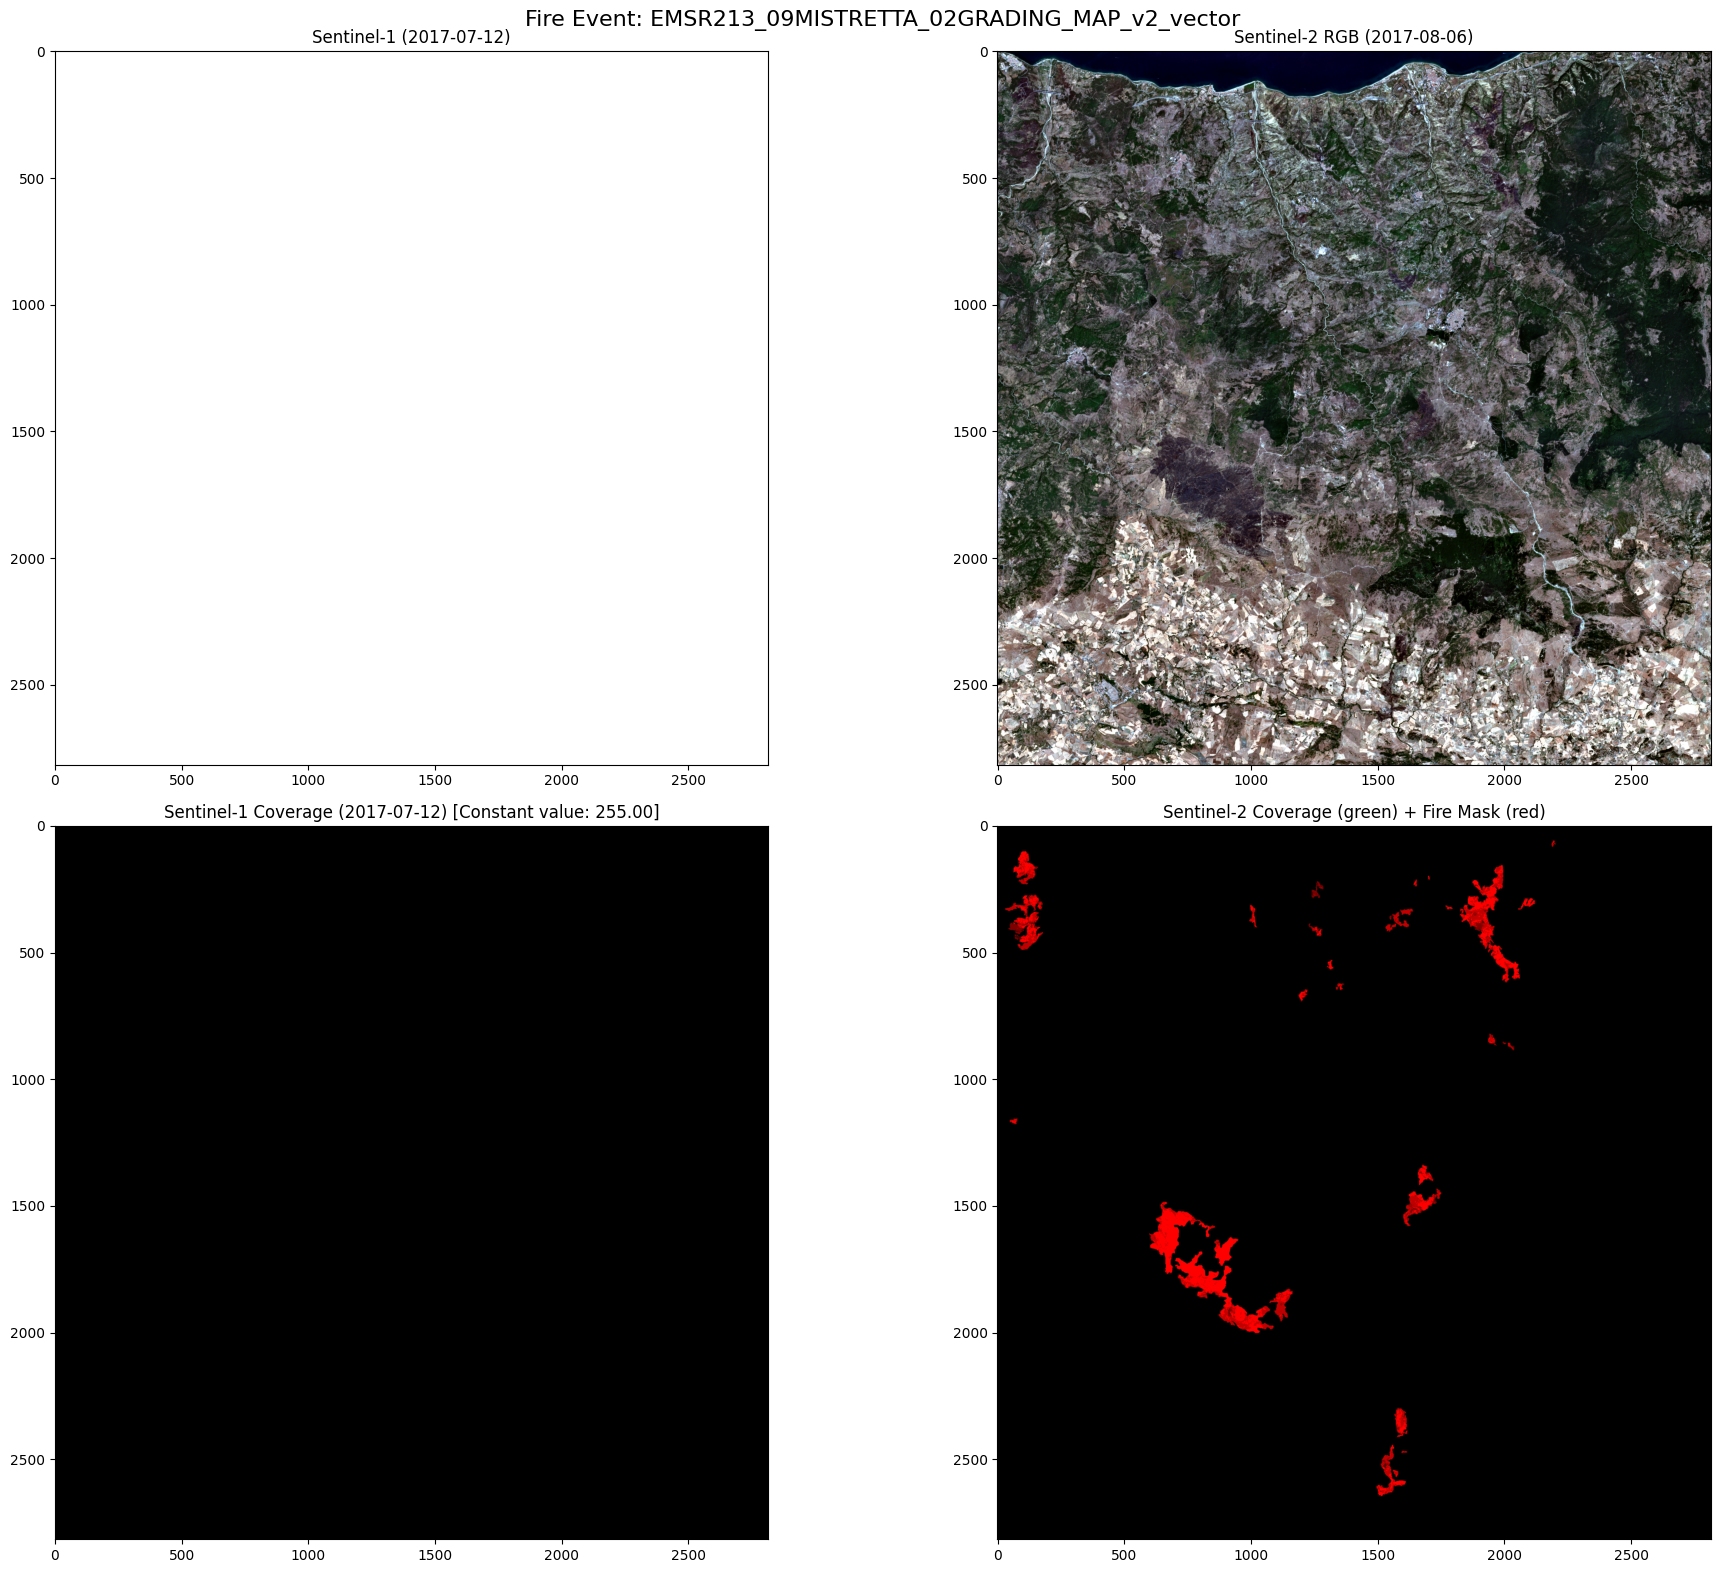

(array([[[0.101     , 0.0978    , 0.0957    , ..., 0.1399    ,
          0.1821    , 0.21      ],
         [0.0554    , 0.0785    , 0.0957    , ..., 0.0738    ,
          0.1439    , 0.2165    ],
         [0.0738    , 0.0683    , 0.0957    , ..., 0.0179    ,
          0.1221    , 0.199     ],
         ...,
         [0.1047    , 0.1206    , 0.1995    , ..., 0.1223    ,
          0.0763    , 0.0843    ],
         [0.1363    , 0.153     , 0.1776    , ..., 0.1923    ,
          0.1093    , 0.0812    ],
         [0.091     , 0.1037    , 0.1026    , ..., 0.1223    ,
          0.0802    , 0.0615    ]],
 
        [[0.1118    , 0.1084    , 0.0492    , ..., 0.0468    ,
          0.0602    , 0.0412    ],
         [0.0504    , 0.0574    , 0.047     , ..., 0.0694    ,
          0.0526    , 0.0822    ],
         [0.0688    , 0.0226    , 0.0492    , ..., 0.121     ,
          0.0626    , 0.1192    ],
         ...,
         [0.0576    , 0.0624    , 0.0528    , ..., 0.0362    ,
          0.0446    , 0.

In [49]:
# Basic usage with automatic date selection
reconstruct_and_visualize_fire_event("EMSR213_09MISTRETTA_02GRADING_MAP_v2_vector",
                                     base_path=tile_dir)